# Computational Exercise 7: Transfer Learning

**It is recommended that you complete this exercise in Google Colab:**
- otherwise you may encounter errors
- this will allow you to access free GPU resources

---
In this exercise, we'll use transfer learning to train the convolutional neural network (CNN) used in our earlier activity, Inception v3, to classify images of flowers. A very similar process was used by Esteva et al. to classify skin lesions.

**This exercise should be completed using a GPU runtime in Colab.**

As in that activity, we'll be importing `tensorflow` as well as `tensorflow_hub`, which will help us load an Inception v3 model that has already been trained (i.e. *pre*-trained) on ImageNet.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_hub as hub

Let's begin by using `tensorflow_hub` to load Inception v3. I found this URL by searching available models on [TensorFlow Hub](https://tfhub.dev). This step may take a minute or two. Once it's complete, we'll have the pre-trained Inception v3 model as a [SavedModel object](https://www.tensorflow.org/guide/saved_model) called `inception_v3`.

**Important Note**: This is a *different* version of Inception v3 compared to the one we used in an earlier activity. In this version, the final layer (i.e. the *classification head*) has been removed.

In [2]:
INCEPTION_V3_URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
INPUT_SIZE = 299
inception_v3 = hub.load(INCEPTION_V3_URL)

## Part 1: Identifying Flowers

In the first half of this activity, we'll re-train the final layer of Inception v3 to identify several types of flowers. The next few blocks use code from a [Tensorflow Transfer Learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub). We begin by downloading the dataset using a function provided by Tensorflow.

In [3]:
flowers_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228827136/228813984 [==============================] - 2s 0us/step


We can now build our dataset directly from the downloaded files, again using a utility provided by Tensorflow. This utility provides a data pipeline that will:
- Load all images in batches during training along with their associated labels. The labels are determined by the directory structure in the archive we downloaded.
- Resize all images to (299, 299) as required for Inception v3.
- Convert the images and labels to Tensorflow tensors ready to be fed through a Tensorflow graph.
- Divide the data into training and test sets.

We'll also need to use a Rescaling layer to make sure the pixels in our images will range from 0 to 1 rather than 0 to 255.

**The details of the code in this block are not important, but it is important that you understand why these steps above are needed.**

Finally, we'll add a few lines to tell Tensorflow to pre-fetch images into memory, which will speed up the training process.

In [4]:
FLOWER_CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

train_flowers = tf.keras.preprocessing.image_dataset_from_directory(
  flowers_root,
  validation_split=0.2,
  subset="training",
  seed=123,
  class_names=FLOWER_CLASSES,
  image_size=(INPUT_SIZE, INPUT_SIZE),
  batch_size=32
)

test_flowers = tf.keras.preprocessing.image_dataset_from_directory(
  flowers_root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  class_names=FLOWER_CLASSES,
  image_size=(INPUT_SIZE, INPUT_SIZE),
  batch_size=32
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_flowers = train_flowers.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_flowers = test_flowers.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_flowers = train_flowers.cache().prefetch(buffer_size=AUTOTUNE)
test_flowers = test_flowers.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Exercise 8.1: Visualize the Flowers Dataset

Similar to previous exercises, we can use `plt.imshow` to plot images in a batch generated by our `train_flowers` Dataset. In the following block, you should plot and label these images.

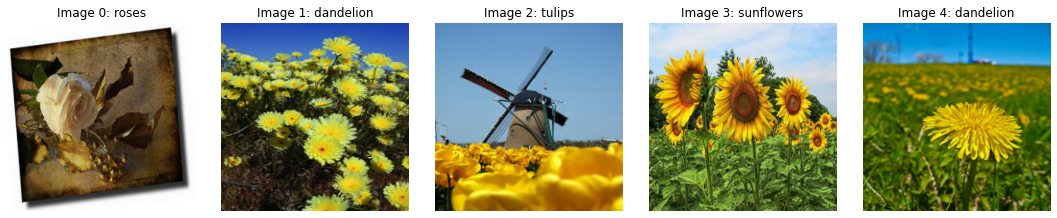

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

# get a single batch
images, labels = next(iter(train_flowers))

for i in range(5):

  ## ADD CODE TO PLOT THE IMAGE ##
  ax[i].imshow(images[i])

  ## ADD CODE TO TITLE THE IMAGE WITH THE CORRESPONDING LABEL ##
  ax[i].set_title('Image %i: %s' % (i, FLOWER_CLASSES[labels[i]]))
  
  # turn off the axes to make the images look nice
  ax[i].axis('off')

plt.tight_layout()
plt.show()

We're now ready to create our prediction model following the steps described in our [medical image analysis lecture](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/ll3.pdf):
- Start with our Inception v3 feature extractor. The classification head (i.e. final layer) has already been removed, but we do need to convert this from a Tensorflow Hub model to a Layer object that can be incorporated in our new, flower prediction model.
- Note that we're saying `trainable=False`, which tells Tensorflow that the existing Inception v3 layers are *not* trainable. In other words, we will be training only our new flower prediction head, not fine-tuning Inception v3. If we *did* want to fine-tune, we'd need much more images, and more time. However, in terms of the coding required at this stage, all we'd need to do is pass `trainable=True` instead.
- Add a Dense (i.e. fully-connected) layer that will predict the image label (i.e. flower type) based on the extracted features. We will be learning the weights in this new layer.

We can now use `model.summary()` to see a description of our model. Note that our single `keras_layer` is actually the entire Inception v3 CNN, which is why it contains so many parameters.

In [9]:
feature_extractor = hub.KerasLayer(
  inception_v3,
  input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
  trainable=False)

# replace the classification head

model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(len(FLOWER_CLASSES))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


To begin training, we'll first need to define our loss, and our optimizer, just as we did in our previous computational exercise.

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # multi-class cross-entropy loss
optimizer = tf.keras.optimizers.Adam() # modified stochastic gradient descent optimizer

## Exercise 8.2: Train the Flowers Model and Evaluate Performance

We're now ready to train our model, which we can do with the following block. Again, this is identical to code we used in the previous exercise. However, this time you should **make the following adjustments**:
- Try training for more epochs
- Add code to monitor accuracy on the training set and test set after each epoch
- After the training process has completed, plot training and test performance by epoch. Is your model overfitting?

In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):

    train_accuracy = []
    test_accuracy = []
  
    for images, labels in train_flowers:
    
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)

        train_accuracy.append(np.mean(np.argmax(predictions, axis=1) == labels))
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    for images, labels in test_flowers:

        predictions = model(images)
        test_accuracy.append(np.mean(np.argmax(predictions, axis=1) == labels))
        
    print('Completed epoch % i | Train accuracy = %.1f | Test accuracy = %.1f' % (epoch, 100 * np.mean(train_accuracy), 100 * np.mean(test_accuracy)))

Completed epoch  0 | Train accuracy = 74.4 | Test accuracy = 86.8
Completed epoch  1 | Train accuracy = 88.1 | Test accuracy = 89.5
Completed epoch  2 | Train accuracy = 90.8 | Test accuracy = 90.0
Completed epoch  3 | Train accuracy = 92.7 | Test accuracy = 90.5
Completed epoch  4 | Train accuracy = 94.1 | Test accuracy = 91.1
Completed epoch  5 | Train accuracy = 94.9 | Test accuracy = 91.0
Completed epoch  6 | Train accuracy = 95.5 | Test accuracy = 91.1
Completed epoch  7 | Train accuracy = 96.2 | Test accuracy = 91.3
Completed epoch  8 | Train accuracy = 96.6 | Test accuracy = 90.7
Completed epoch  9 | Train accuracy = 97.0 | Test accuracy = 90.9


## Exercise 8.3: Make Predictions and Inspect Them

We're done training! We've already taken a look at the accuracy, but let's also inspect a few images in the test set. In the following block, you should plot at least 5 test images along with (a) the predicted label, and (b) the true label.

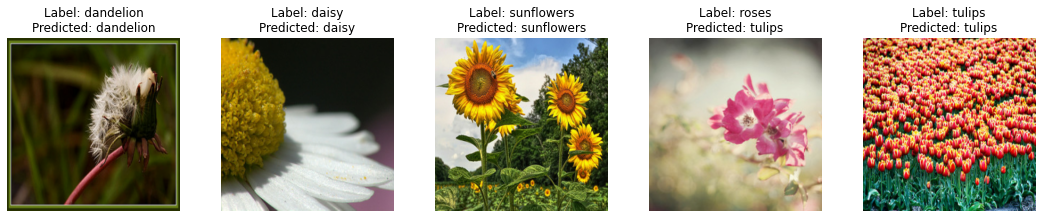

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

images, labels = next(iter(test_flowers))

## ADD CODE TO PREDICT THE LABELS FOR THIS BATCH OF TEST IMAGES ##
predicted_labels = np.argmax(model(images), axis=1)

for i in range(5):

  ## ADD CODE TO PLOT THE IMAGE ##
  ax[i].imshow(images[i])

  ## ADD CODE TO TITLE THE IMAGE WITH THE PREDICTED AND TRUE LABELS ##
  ax[i].set_title('Label: %s\nPredicted: %s' % (FLOWER_CLASSES[labels[i]], FLOWER_CLASSES[predicted_labels[i]]))  
  
  # turn off the axes to make the images look nicer
  ax[i].axis('off')

plt.tight_layout()
plt.show()

## Part 2: Mammograms

In the second half of this activity, we'll re-train the final layer of Inception v3 to identify types of breast tissue from [the mini-MIAS database of mammograms](http://peipa.essex.ac.uk/info/mias.html). This dataset is very small, which makes it easy to work with in a short amount of time. While we're unlikely to get good accuracy with a dataset of this size, the same process could be used to obtain good performance on a larger dataset. We'll begin by downloading the data the same way we downloaded the flowers dataset.

In [14]:
mias_root = tf.keras.utils.get_file(
  origin='http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz',
  untar=True)

111165440/111154265 [==============================] - 9s 0us/step


We can now build our dataset from the downloaded files. This time, we'll build the dataset manually instead of using a Tensorflow function. This will make it easier to see all the individual steps, but will use more RAM than we did before, because all the images will be stored in memory. Steps include:
- Load all images in the directory we downloaded using `cv2`.
- Resize all images to (299, 299) and rescale their pixels to range from 0 to 1, as required for Inception v3.
- Convert the images and labels to Tensorflow tensors ready to be fed through a Tensorflow graph.
- Use pandas to read a table containing information corresponding to each image, including the tissue type and severity of any abnormalities. We will be predicting tissue type rather than severity, because the latter only exists for images that contain abnormalities.
- Divide the data into training and test sets.

**The details of the code in this block are not important, but it is important that you understand why these steps above are needed.**

After running this block, you may want to take a look at `mias_df`, which contains information about each image, as well as the shape of `mias_images`.

In [15]:
import cv2

def read_image(fn, size=(INPUT_SIZE, INPUT_SIZE)):
  img = cv2.imread(fn)[:, :, ::-1]
  img = cv2.resize(img, size)
  return img / 255.

mias_df = pd.read_table(
    os.path.join(os.path.dirname(mias_root), 'Info.txt'),
    sep=' ',
    skiprows=101,
    skipfooter=2,
    header=None,
    names=['id', 'tissue', 'type', 'severity', 'x_coord', 'y_coord', 'radius']
)[['id', 'tissue', 'type']].drop_duplicates().sample(frac=1., random_state=2021)

mias_filenames = os.listdir(os.path.dirname(mias_root))
mias_ids = [fn.split('.')[0] for fn in mias_filenames]
mias_df = mias_df[mias_df['id'].isin(mias_ids)]

mias_labels, mias_classes = pd.factorize(mias_df['tissue'])
mias_images = np.array([read_image(os.path.join(os.path.dirname(mias_root), str(id) + '.pgm')) for id in mias_df['id']])

train_mias = tf.data.Dataset.from_tensor_slices((mias_images[:(23 * 12)], mias_labels[:(23 * 12)])).batch(23)
test_mias = tf.data.Dataset.from_tensor_slices((mias_images[(23 * 12):], mias_labels[(23 * 12):])).batch(23)

/usr/local/lib/python3.7/dist-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


## Exercise 8.4: Visualize the mini-MIAS Dataset

This time, even though we did create Tensorflow Datasets to use in training (`train_mias` and `test_mias`), we can also access the images and labels directly in `mias_images` and `mias_labels`, and `mias_classes` tells us the tissue type corresponding to each label. In the following block, you should plot and label at least 5 images from mini-MIAS.

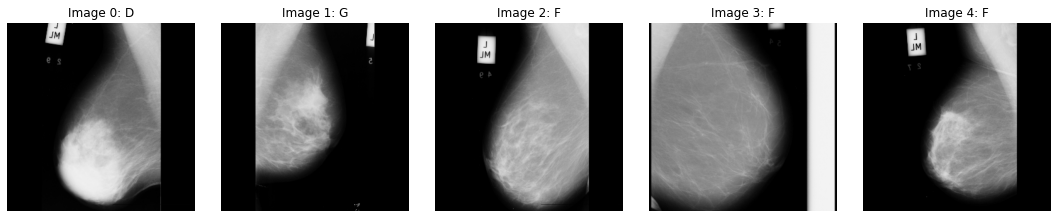

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))

for i in range(5):

  ## ADD CODE TO PLOT THE IMAGE ##
  ax[i].imshow(mias_images[i])

  ## ADD CODE TO TITLE THE IMAGE WITH THE CORRESPONDING LABEL ##
  ax[i].set_title('Image %i: %s' % (i, mias_classes[mias_labels[i]]))
  
  # turn off the axes to make the images look nice
  ax[i].axis('off')

plt.tight_layout()
plt.show()

Once again, we're ready to create our prediction model following the steps described in our [medical image analysis lecture](https://github.com/mengelhard/bsrt_ml4h/blob/master/lectures/ll3.pdf):
- Start with our Inception v3 feature extractor. The classification head (i.e. final layer) has already been removed, but we do need to convert this from a Tensorflow Hub model to a Layer object that can be incorporated in our new, flower prediction model.
- We'll stick with `trainable=False`. It may be interesting to try `trainable=True`, but it's unlikely to work well with such a small dataset. If we had a large enough dataset to support this, we'd need a lot more time.
- Add a Dense (i.e. fully-connected) layer that will predict the image label (i.e. tissue type) based on the extracted features. We will be learning the weights in this new layer.

We can now use `model.summary()` to see a description of our model. Again, our single `keras_layer` is actually the entire Inception v3 CNN, which is why it contains so many parameters.

In [17]:
feature_extractor = hub.KerasLayer(
  inception_v3,
  input_shape=(INPUT_SIZE, INPUT_SIZE, 3),
  trainable=False)

# replace the classification head

model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(len(mias_classes))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


We'll use the same loss and optimizer as before.

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # multi-class cross-entropy loss
optimizer = tf.keras.optimizers.Adam() # modified stochastic gradient descent optimizer

## Exercise 8.5: Train the MIAS Model and Evaluate Performance

Now we're ready to start training! You should modify the code below the same way you did before:
- Evaluate accuracy on the training set and test set after each epoch
- Additionally, it may be helpful to evaluate performance on the test set before we start training so we know what our starting point is.

In [20]:
EPOCHS = 10

test_accuracy = []

for images, labels in test_mias:
  
  predictions = model(images)
  test_accuracy.append(np.mean(np.argmax(predictions, axis=1) == labels))

print('Prior to training, test accuracy was %.1f' % (100 * np.mean(test_accuracy)))

for epoch in range(EPOCHS):

    train_accuracy = []
    test_accuracy = []
  
    for images, labels in train_mias:
    
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)

        train_accuracy.append(np.mean(np.argmax(predictions, axis=1) == labels))
    
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    for images, labels in test_mias:

        predictions = model(images)
        test_accuracy.append(np.mean(np.argmax(predictions, axis=1) == labels))
        
    print('Completed epoch % i | Train accuracy = %.1f | Test accuracy = %.1f' % (epoch, 100 * np.mean(train_accuracy), 100 * np.mean(test_accuracy)))

Prior to training, test accuracy was 41.3
Completed epoch  0 | Train accuracy = 40.2 | Test accuracy = 37.0
Completed epoch  1 | Train accuracy = 59.4 | Test accuracy = 58.7
Completed epoch  2 | Train accuracy = 70.7 | Test accuracy = 65.2
Completed epoch  3 | Train accuracy = 76.8 | Test accuracy = 60.9
Completed epoch  4 | Train accuracy = 78.6 | Test accuracy = 60.9
Completed epoch  5 | Train accuracy = 79.3 | Test accuracy = 67.4
Completed epoch  6 | Train accuracy = 80.8 | Test accuracy = 71.7
Completed epoch  7 | Train accuracy = 82.6 | Test accuracy = 73.9
Completed epoch  8 | Train accuracy = 83.7 | Test accuracy = 73.9
Completed epoch  9 | Train accuracy = 84.1 | Test accuracy = 69.6


When training a model like this, in addition to the fact that you'll typically be working with a much larger dataset, there are a few additional factors to consider, including:
- The depth to which you'll fine-tune. To adjust this, we'd need code to set individual layers within Inception v3 to `trainable=True` or `trainable=False` rather than Inception v3 as a whole.
-  Data augmentation, which typically includes random crops, rotations, and other distortions.

Still, this code provides the general road map you'd need to make predictions on your own dataset of medical images.

### Once you've completed these exercises, please turn in the assignment as follows:

If you're using Anaconda on your local machine:
- download your notebook as html (see File > Download as > HTML (.html))
- submit the resulting file as your assignment
- if .html files are not accepted, .zip the file (i.e. place it in a .zip archive) and submit the .zip file instead

If you're using Google Colab:
- download your notebook as .ipynb (see File > Download > Download .ipynb)
- if you have nbconvert installed, convert it to .html; if not, leave is as .ipynb
- submit the resulting file as your assignment
- if this file is not accepted, .zip the file (i.e. place it in a .zip archive) and submit the .zip file instead